In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data_utils
from torch.utils.data import DataLoader, TensorDataset
from torch.utils.data import Dataset
from torch.utils import data
import pandas as pd
import numpy as np
from torch.autograd import Variable, grad
from sklearn.preprocessing import LabelEncoder,StandardScaler

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
file_path ="/content/drive/My Drive/Colab Notebooks/final_203.csv"

In [ ]:
df=pd.read_csv(file_path,index_col=0)

In [ ]:
df.index.name=None
df

,A4GNT,AADAC,ABCB1,ABCB7,ABCG2,ABHD15,ABLIM1,ABRAXAS2,ACAA1,ACBD4,...,ZNF697,ZNF710,ZNF732,ZNF773,ZNF821,ZNFX1,ZSWIM5,ZWILCH,ZYX,Diagnosis
PB102_C,0.000000,2.334359,408.094296,568.122373,501.199502,542.753648,5160.178728,271.086737,1425.662644,496.138837,...,326.835790,1018.824046,0.000000,840.318137,65.121200,1917.993875,532.594744,161.483019,923.200041,CD
PB103_C,26.648401,40.489413,420.660674,1079.818574,276.115841,625.863588,6356.313750,348.235597,1101.880125,528.829229,...,386.532699,698.747896,39.484771,1461.459406,210.118150,3419.360644,581.046805,498.706155,1060.862346,CD
PB104_C,2.966024,2.342426,171.499841,614.392622,55.679350,421.435699,3224.032671,278.643464,988.428169,291.816771,...,524.303695,805.103295,5.171647,959.624562,46.257377,3400.282500,205.240032,202.439291,2583.210794,CD
PB105_C,0.000000,10.357199,179.641904,885.261289,240.383561,482.522349,5322.598032,290.110205,958.638893,367.977976,...,425.031057,840.092668,20.115012,1107.583760,108.130097,2562.507168,543.988495,229.186990,1122.925861,CD
PB106_C,6.921331,5.640569,208.562851,870.830686,402.519985,614.970268,4441.217079,269.724701,1608.168373,516.053199,...,312.062237,944.963038,19.476250,1334.002607,45.340591,2944.329514,438.241194,329.400131,668.429799,CD
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
PNIBD50_I,1.973950,793.086449,5337.527525,1265.843232,5282.481959,1148.798810,5716.980897,451.449386,3155.104227,1186.762916,...,421.278573,694.025835,8.637912,1153.167517,266.380941,3157.360102,1092.840375,400.485253,1225.607688,nonIBD
PNIBD53_I,0.998809,226.796297,2749.946237,1417.011251,1483.433794,1069.860903,6899.820983,547.232635,1922.124461,778.635837,...,239.813412,916.917247,14.754006,1384.008062,258.012734,4090.840810,641.970119,525.901468,1685.625478,nonIBD
PNIBD54_I,0.000000,1681.370333,7796.217242,1104.756141,9245.290959,1098.426668,7026.769641,474.490462,3506.315952,1051.099116,...,498.402764,1038.237729,6.414935,1018.359181,246.660634,3340.686752,1436.789737,322.705896,1017.462141,nonIBD
PNIBD55_I,0.000000,463.460963,3808.102994,1126.050591,3367.837483,1007.019868,9375.282158,527.380785,2978.139740,885.804022,...,365.507111,917.468944,17.893713,1140.038916,241.059044,3518.762437,692.855526,349.435853,1429.844551,nonIBD


In [ ]:
def preprocess_data(df):
    # Drop rows with missing values
    #df = df.dropna()
    features=df.drop(columns=['Diagnosis'])
    labels=df['Diagnosis']
    # Normalize the features
    #scaler = StandardScaler()
    #features = scaler.fit_transform(features)
    label_encoder=LabelEncoder()
    labels=torch.tensor(label_encoder.fit_transform(labels.values)).float()

    features=torch.tensor(features.values).float()
    return features,labels


In [ ]:
class Generator(nn.Module):
  def __init__(self, noise_dim, output_dim):
      super(Generator,self).__init__()
      #self.label_emb=nn.Embedding(n_disease_types,latent_dim)
      self.model=nn.Sequential(
        nn.Linear(noise_dim,128),
        nn.ReLU(),
        nn.Linear(128,256),
        nn.ReLU(),
        nn.Linear(256,output_dim)

    )

  def forward(self,z):
       return self.model(z)

In [ ]:
class Critic(nn.Module):
  def __init__(self, input_dim):
    super(Critic,self).__init__()
    #self.label_emb=nn.Embedding(n_disease_types,n_genes)
    self.model =nn.Sequential(
        nn.Linear(input_dim,256),
        nn.LeakyReLU(0.2),
        nn.Linear(256,128),
        nn.LeakyReLU(0.2),
        nn.Linear(128,1)
    )
  def forward(self,x):
    return self.model(x)
        #nn.ReLU(True),
        #nn.Linear(512,256),
        #nn.ReLU(True),
        #nn.Linear(256,128),
        #nn.LeakyReLU(0.2),
        #nn.Linear(256,1)


In [ ]:
def train_wgan(generator, critic, dataloader, num_epochs, noise_dim, device):
    optimizer_G=optim.RMSprop(generator.parameters(),lr=0.000001)
    optimizer_C=optim.RMSprop(critic.parameters(),lr=0.000001)

    for epoch in range(num_epochs):
        for real_samples, _ in dataloader:
            real_samples=real_samples.to(device)

            for _ in range(5):
              # Train the critic
                optimizer_C.zero_grad()
                z=torch.randn(real_samples.size(0),noise_dim).to(device)
                fake_samples=generator(z).detach()

                critic_loss=-(critic(real_samples).mean()-critic(fake_samples).mean())
                critic_loss.backward()
                optimizer_C.step()

                for p in critic.parameters():
                  p.data.clamp_(-0.01,0.01)

            optimizer_G.zero_grad()
            z=torch.randn(real_samples.size(0),noise_dim).to(device)
            fake_samples=generator(z)
            generator_loss=-critic(fake_samples).mean()
            generator_loss.backward()
            optimizer_G.step()


        print(f"Epoch [{epoch+1}/{num_epochs}] - Critic Loss: {critic_loss.item():.4f}, Generator Loss: {generator_loss.item():.4f}")

In [ ]:
def prepare_dataloader(features,labels,batch_size):
    ibd_data=features[labels==1]
    non_ibd_data=features[labels==0]

    min_samples=min(len(ibd_data),len(non_ibd_data))
    ibd_data=ibd_data[:min_samples]
    non_ibd_data=non_ibd_data[:min_samples]

    balanced_data=torch.cat((ibd_data,non_ibd_data),dim=0)
    balanced_labels=torch.cat([torch.ones(min_samples),torch.zeros(min_samples)],dim=0)

    dataset=TensorDataset(balanced_data,balanced_labels)
    dataloader= DataLoader(dataset,batch_size=batch_size,shuffle=True)
    return dataloader

In [ ]:
def generate_syn_samples(generator,num_samples,noise_dim,device):
    generator.eval()
    z=torch.randn(num_samples,noise_dim).to(device)
    with torch.no_grad():
        syn_samples=generator(z)
    return syn_samples


In [ ]:
noise_dim=128
input_dim=1328
num_epochs=1000
batch_size=64

In [ ]:
features,labels=preprocess_data(df)

In [ ]:
#features,labels

In [ ]:
generator=Generator(noise_dim,input_dim).to(device)
critic=Critic(input_dim).to(device)

In [ ]:
dataloader= prepare_dataloader(features,labels,batch_size)
dataloader

In [ ]:
train_wgan(generator,critic,dataloader,num_epochs,noise_dim,device)

Epoch [1/1000] - Critic Loss: -1.3412, Generator Loss: 0.0090
Epoch [2/1000] - Critic Loss: -4.2642, Generator Loss: 0.0090
Epoch [3/1000] - Critic Loss: -4.3100, Generator Loss: 0.0089
Epoch [4/1000] - Critic Loss: -8.5980, Generator Loss: 0.0089
Epoch [5/1000] - Critic Loss: -8.9387, Generator Loss: 0.0090
Epoch [6/1000] - Critic Loss: -9.6618, Generator Loss: 0.0089
Epoch [7/1000] - Critic Loss: -13.4090, Generator Loss: 0.0089
Epoch [8/1000] - Critic Loss: -15.4413, Generator Loss: 0.0088
Epoch [9/1000] - Critic Loss: -19.5782, Generator Loss: 0.0088
Epoch [10/1000] - Critic Loss: -18.8572, Generator Loss: 0.0088
Epoch [11/1000] - Critic Loss: -21.5195, Generator Loss: 0.0088
Epoch [12/1000] - Critic Loss: -25.7621, Generator Loss: 0.0088
Epoch [13/1000] - Critic Loss: -26.6867, Generator Loss: 0.0088
Epoch [14/1000] - Critic Loss: -26.3543, Generator Loss: 0.0088
Epoch [15/1000] - Critic Loss: -29.8097, Generator Loss: 0.0087
Epoch [16/1000] - Critic Loss: -31.9930, Generator Loss

In [ ]:
num_syn_samples=500
syn_samples=generate_syn_samples(generator,num_syn_samples*2,noise_dim,device)

In [ ]:
syn_ibd_samples=syn_samples[:num_syn_samples]
syn_non_ibd_samples=syn_samples[num_syn_samples:]

In [ ]:
print(syn_ibd_samples.shape)
print(syn_non_ibd_samples.shape)

torch.Size([500, 1328])
torch.Size([500, 1328])


In [ ]:
print("Synthetic IBD Samples:")
print(syn_ibd_samples)
print("\nSynthetic Non-IBD Samples:")
print(syn_non_ibd_samples)

Synthetic IBD Samples:
tensor([[-0.0090,  0.0523,  0.0541,  ...,  0.1377,  0.1428,  0.1446],
        [ 0.0623,  0.0186,  0.1160,  ...,  0.2149, -0.0419,  0.1708],
        [-0.1075, -0.0714,  0.1126,  ...,  0.1312, -0.0066,  0.4323],
        ...,
        [ 0.0841, -0.0763, -0.0461,  ...,  0.2574, -0.0462,  0.2288],
        [-0.0219,  0.0122,  0.0711,  ...,  0.0772,  0.0393,  0.2833],
        [ 0.0841,  0.0506,  0.0234,  ...,  0.1307,  0.0957,  0.2373]])

Synthetic Non-IBD Samples:
tensor([[-0.0305,  0.0171, -0.0092,  ...,  0.3682,  0.0134,  0.4303],
        [ 0.0093, -0.0602,  0.2756,  ...,  0.3048,  0.0372,  0.3291],
        [ 0.1458,  0.0991,  0.1326,  ...,  0.0781,  0.0768,  0.2200],
        ...,
        [-0.1069,  0.0510,  0.0686,  ...,  0.3047, -0.0094,  0.3358],
        [-0.0556, -0.0122,  0.0932,  ...,  0.0215,  0.1434,  0.4669],
        [ 0.0453,  0.0127,  0.1011,  ...,  0.2155,  0.0142,  0.3482]])


In [ ]:
syn_ibd_samples_np=syn_ibd_samples.cpu().detach().numpy()
syn_non_ibd_samples_np=syn_non_ibd_samples.cpu().detach().numpy()

In [ ]:
gene_names=df.columns[:-1]

In [ ]:
syn_ibd_df=pd.DataFrame(syn_ibd_samples_np,columns=gene_names)
syn_non_ibd_df=pd.DataFrame(syn_non_ibd_samples_np,columns=gene_names)


In [ ]:
syn_ibd_df['Diagnosis']='IBD'
syn_non_ibd_df['Diagnosis']='Non-IBD'

In [ ]:
syn_samples_df=pd.concat([syn_ibd_df,syn_non_ibd_df],ignore_index=True)

In [ ]:
syn_samples_df.to_csv('/content/drive/My Drive/Colab Notebooks/syn_203_512_0.000001.csv',index=False)

In [ ]:
df_new=pd.read_csv('/content/drive/My Drive/Colab Notebooks/syn_203_512_0.000001.csv')
df_new

,A4GNT,AADAC,ABCB1,ABCB7,ABCG2,ABHD15,ABLIM1,ABRAXAS2,ACAA1,ACBD4,...,ZNF697,ZNF710,ZNF732,ZNF773,ZNF821,ZNFX1,ZSWIM5,ZWILCH,ZYX,Diagnosis
0,-0.008958,0.052317,0.054125,0.314148,0.157876,0.055657,0.233780,0.097522,-0.005772,-0.028277,...,0.144362,0.049612,0.228691,0.117947,0.169097,0.139003,0.137656,0.142838,0.144577,IBD
1,0.062328,0.018633,0.116039,0.381507,0.186001,0.242728,0.215478,0.155458,0.044448,0.140527,...,0.168552,0.068677,0.039394,0.099071,0.070843,0.162939,0.214885,-0.041889,0.170809,IBD
2,-0.107502,-0.071387,0.112648,0.312702,-0.014907,0.152052,0.366062,0.098487,0.020403,0.078175,...,0.376574,0.147632,0.011688,0.097665,0.384091,0.137933,0.131158,-0.006620,0.432316,IBD
3,-0.076757,-0.036766,0.162638,0.479960,0.100786,0.206962,0.225480,0.213584,0.069133,0.154895,...,0.179451,0.147996,-0.013874,0.211948,0.378480,-0.009890,0.132259,0.033656,0.371970,IBD
4,-0.039639,0.094936,0.049441,0.252361,0.160893,-0.005588,0.217446,0.210064,0.057931,0.107060,...,0.140515,0.100286,0.005361,0.006945,0.112732,-0.047099,0.246611,0.048923,0.220391,IBD
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,0.001447,-0.033202,0.101862,0.191895,0.043207,0.053257,0.084186,0.033378,-0.069397,0.034548,...,0.283611,0.172466,0.152902,0.096962,0.220790,0.064046,0.149872,0.082085,0.218366,Non-IBD
996,0.065844,-0.060453,0.160790,0.505733,0.108740,0.145832,0.234020,0.015718,-0.111749,0.024053,...,0.195186,0.133695,0.014121,0.245278,0.164507,-0.106691,0.169148,-0.032770,0.298969,Non-IBD
997,-0.106873,0.050964,0.068590,0.333671,0.034859,0.256207,0.251469,0.155143,0.220578,0.217493,...,0.261946,0.297809,0.113302,-0.027889,0.239166,0.142786,0.304692,-0.009406,0.335801,Non-IBD
998,-0.055643,-0.012161,0.093199,0.284765,0.211527,0.076941,0.140558,0.020651,-0.151947,0.052166,...,0.022597,0.261096,0.166118,0.061322,0.073580,0.129547,0.021487,0.143353,0.466907,Non-IBD


In [ ]:
def compute_stat(data, labels):
    data_np = data.cpu().numpy() if isinstance(data, torch.Tensor) else data.to_numpy()
    ibd_data = torch.tensor(data_np[labels == 1])
    non_ibd_data = torch.tensor(data_np[labels == 0])
    return{
        "IBD Mean":torch.mean(ibd_data,dim=0),
        "IBD Var":torch.var(ibd_data,dim=0),
        "Non IBD Mean":torch.mean(non_ibd_data,dim=0),
        "Non IBD Var":torch.var(non_ibd_data,dim=0)
        }

real_stats=compute_stat(features,labels)
print("Real Data Statistics:")
print(real_stats)
diagnosis_mapping = {'IBD': 1, 'Non-IBD': 0}
syn_labels = df_new['Diagnosis'].map(diagnosis_mapping)
syn_stats = compute_stat(syn_samples_df.drop(columns=['Diagnosis']), torch.tensor(syn_labels.values))
print("\nSynthetic Data Statistics:")
print(syn_stats)

Real Data Statistics:
{'IBD Mean': tensor([   9.6885,  414.0720, 3560.0178,  ...,  847.6092,  448.2248,
        1341.5015]), 'IBD Var': tensor([6.5705e+03, 4.0543e+05, 9.0812e+06,  ..., 9.4800e+04, 2.6129e+04,
        1.9065e+05]), 'Non IBD Mean': tensor([   6.0459,  121.3185, 1573.0078,  ...,  546.7855,  297.6996,
        1408.6769]), 'Non IBD Var': tensor([3.5994e+02, 5.8031e+04, 3.0520e+06,  ..., 7.6057e+04, 1.7491e+04,
        4.5813e+05])}

Synthetic Data Statistics:
{'IBD Mean': tensor([-0.0103,  0.0157,  0.0735,  ...,  0.2091,  0.0370,  0.2955]), 'IBD Var': tensor([0.0066, 0.0070, 0.0072,  ..., 0.0089, 0.0078, 0.0099]), 'Non IBD Mean': tensor([-0.0033,  0.0035,  0.0733,  ...,  0.2135,  0.0361,  0.3042]), 'Non IBD Var': tensor([0.0062, 0.0068, 0.0074,  ..., 0.0090, 0.0080, 0.0094])}


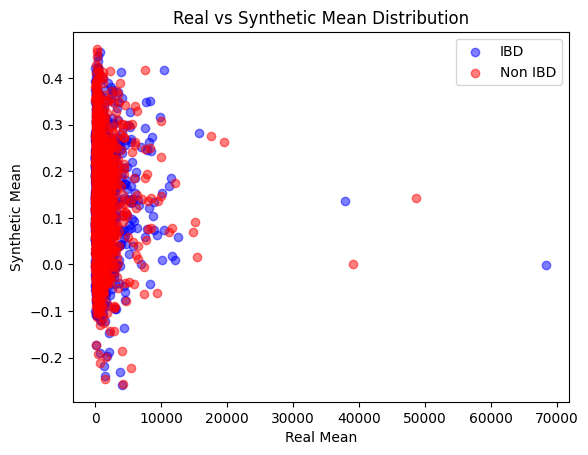

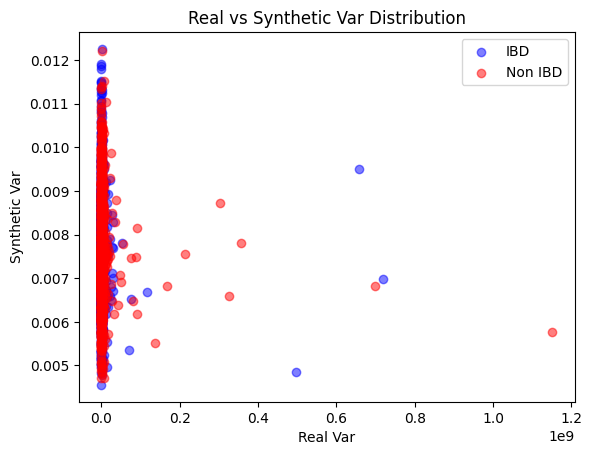

In [ ]:
import matplotlib.pyplot as plt
def plot_stats(real_stats,syn_stats,stat_type="Mean"):
    plt.scatter(real_stats[f"IBD {stat_type}"].numpy(),
                syn_stats[f"IBD {stat_type}"].numpy(),
                alpha=0.5,label="IBD",color='blue')
    plt.scatter(real_stats[f"Non IBD {stat_type}"].numpy(),
                syn_stats[f"Non IBD {stat_type}"].numpy(),
                alpha=0.5,label="Non IBD",color='red')
    plt.title(f"Real vs Synthetic {stat_type} Distribution")
    plt.xlabel(f"Real {stat_type}")
    plt.ylabel(f"Synthetic {stat_type}")
    plt.legend()
    plt.show()
plot_stats(real_stats,syn_stats,stat_type="Mean")
plot_stats(real_stats,syn_stats,stat_type="Var")
